In [17]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import time
from IPython import display

import contextlib
import os
from importlib import reload


import gait
from utils import *

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']
plt.rcParams['font.size'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# torch.set_default_dtype(torch.float64)

class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            #self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.ReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [19]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 2, [500, 500]
batch_size_p, batch_size_q = 200, 200

generator = GeneratorFC(z_dim, d, gen_hiddens)#.cuda()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [20]:
emp_probs_p = torch.ones(1, batch_size_p)/batch_size_p #.cuda()
emp_probs_q = torch.ones(1, batch_size_q)/batch_size_q #.cuda()

sigma_mult = 1
kernel = lambda x, y: gait.generic_kernel(x, y, lambda u, v: gait.rbf_kernel(u, v, sigmas=[0.2 * sigma_mult], log=True))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: multiquad_kernel(u, v, sigma=0.2))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: poly_kernel(u, v, degree=2))

D = lambda x, y: gait.breg_mixture_divergence_stable(emp_probs_p, x, emp_probs_q, y, kernel, symmetric=False)

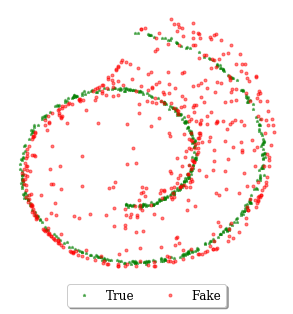

In [16]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-1.5, 1.5),  ax.set_ylim(-1.5, 1.5)
ax.axes.get_xaxis().set_visible(False), ax.axes.get_yaxis().set_visible(False)
for _ in ['top', 'right', 'bottom', 'left']:                
    ax.spines[_].set_visible(False)        
plt.ion()

for _ in range(1000):
    
    g_optimizer.zero_grad()
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10)#.cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_q, z_dim)#.cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)
        loss = D(x_real, x_fake)

        if _ % 50 == 0:
            #print("%d - %.4f" % (_, loss.item()))
            ax.clear()
            x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
            z = torch.randn(500, z_dim)#.cuda()
            x_fake = generator(z).data.numpy()
            
            ax.plot(x_real[:, 0], x_real[:, 1], 'g*', alpha=0.5, label='True', markersize=3)
            ax.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake', markersize=3)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.00), fancybox=True, shadow=True, ncol=2);

            fig.canvas.draw()
            display.display(plt.gcf())
            time.sleep(0)
            display.clear_output(wait=True)

        loss.backward()

    g_optimizer.step()